# SPACESHIP TITANIC
First, I will import the libraries and data needed for analysis.

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
# Load the training dataset (saving the test dataset for final submission)
df_train = pd.read_csv('./data/train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [3]:
# Count and enumerate unique categorical values
for col in df_train.columns:
    column = df_train[col]
    if column.dtype in ('bool', 'object'):
        uniques = column.unique()
        print(f"{col} ({len(uniques)})")
        print(f"{uniques}\n")

PassengerId (8693)
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']

HomePlanet (4)
['Europa' 'Earth' 'Mars' nan]

CryoSleep (3)
[False True nan]

Cabin (6561)
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Destination (4)
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]

VIP (3)
[False True nan]

Name (8474)
['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']

Transported (2)
[False  True]



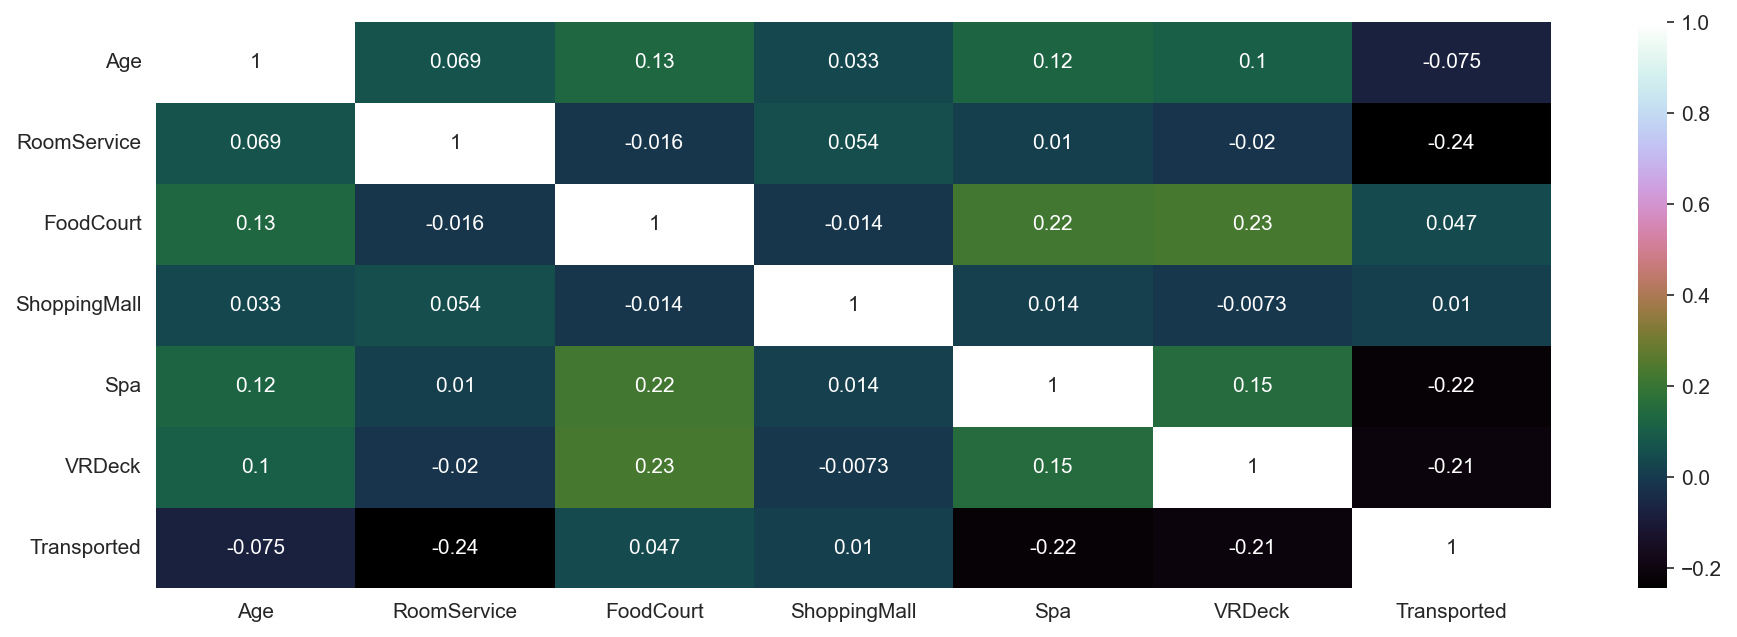

In [4]:
# Show feature correlation heatmap
plt.figure(figsize=(15, 5), dpi=150)
sns.heatmap(df_train.corr(), annot=True, cmap='cubehelix')
plt.show()

# PLAN OF ATTACK
For this analysis, I want to see if there is a performance difference between the predictions on the normal feature space and predictions on a principal component latent space.
<br>
##### **Principal Component Analysis**
There are some binary categorical features, and there are some nominal categorical features. If I use one-hot encoding, then I'll significantly expand the dimensionality, especially with features like `Name` and `Cabin`. However, I wonder if running PCA for dimensionality reduction will prove insightful, possibly by finding otherwise-hidden patterns or clusters in the latent space.
<br>
##### **Artificial Neural Network**
I'll use Keras to build a low-depth neural net, tweaking the parameters (architecture) and hyperparameters (Adam parameters) until the model is complex enough not to underfit to the data and regularized enough not to overfit to the data. Then, I will compare the performance of the neural net on the normal feature space and the PCA latent space.

# FEATURE ENGINEERING: Trial 1
I will fully expand every feature through dummy encoding, then I'll re-reduce dimensionality with PCA. Predictions will be on the latent space. I am concerned that the SVD algorithm won't be able to converge due to the very high dimensionality I'm anticipating.

In [5]:
# Extract features and labels from the training data
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, -1:]
print(f"{X.shape=}")
print(f"{y.shape=}")
X.head()

X.shape=(8693, 13)
y.shape=(8693, 1)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [6]:
# Expand all features
X_clean = pd.get_dummies(X)
X_clean.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerId_0001_01,PassengerId_0002_01,PassengerId_0003_01,PassengerId_0003_02,...,Name_Zinopus Spandisket,Name_Zinor Axlentindy,Name_Zinor Proorbeng,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Flesping,Name_Zubeneb Pasharne
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Standardize the features about the origin
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)
X_scaled[X_scaled.isna()] = 0
X_scaled.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerId_0001_01,PassengerId_0002_01,PassengerId_0003_01,PassengerId_0003_02,...,Name_Zinopus Spandisket,Name_Zinor Axlentindy,Name_Zinor Proorbeng,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Flesping,Name_Zubeneb Pasharne
0,0.702095,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,93.230896,-0.010726,-0.010726,-0.010726,...,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726
1,-0.333233,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,-0.010726,93.230896,-0.010726,-0.010726,...,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726
2,2.013510,-0.272527,1.934922,-0.287317,5.634034,-0.223327,-0.010726,-0.010726,93.230896,-0.010726,...,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726
3,0.287964,-0.337025,0.511931,0.326250,2.655075,-0.097634,-0.010726,-0.010726,-0.010726,93.230896,...,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726
4,-0.885407,0.117466,-0.240833,-0.037590,0.223344,-0.264352,-0.010726,-0.010726,-0.010726,-0.010726,...,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726,-0.010726


In [8]:
# Binarize boolean labels
y_clean = np.zeros(y.shape) + y.to_numpy()
y_clean = pd.DataFrame(y_clean, dtype='uint8')
y_clean.head()

,0
0,0
1,1
2,0
3,0
4,1


In [9]:
# Split 20% of data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_clean, test_size=0.2, shuffle=True, random_state=0)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_val.shape=}")
print(f"{y_val.shape=}")

X_train.shape=(6954, 23742)
y_train.shape=(6954, 1)
X_val.shape=(1739, 23742)
y_val.shape=(1739, 1)


In [10]:
# Code below is retroactively commented out because it doesn't converge.

# Decompose into principal components that explain 95% variance
# pca = PCA(random_state=0).fit(X_train)
# X_train_pca = pca.transform(X_train)
#
# pca_val = PCA(random_state=0).fit(X_val)
# X_val_pca = pca.transform(X_val)
#
# print(f"{X_train_pca.shape=}")
# print(f"{X_val_pca.shape=}")

# FEATURE ENGINEERING: Trial 2
Indeed, the SVD algorithm did not converge because of the dimensionality. To prevent this issue, I'll conduct this trial the same as Trial 1, except I will cleverly encode categorical data instead of naively expanding it.

In [11]:
# Clean up the features

# `Name` and `PassengerId` are unique identifiers, probably not highly correlated to the target
X_clean = X.drop(['Name', 'PassengerId'], axis=1)

# Only dummy encode features with small (<5) expansion
expand_cols = ['HomePlanet', 'Destination']
onehot_cols = pd.get_dummies(X_clean[expand_cols])
X_clean = X_clean.drop(expand_cols, axis=1)
X_clean = X_clean.join(onehot_cols)

# Binarize boolean features
for col in ('CryoSleep', 'VIP'):
    column = X_clean[col].copy()
    column[column.isna()] = 0
    column = np.zeros(column.shape) + column.to_numpy()
    column = pd.Series(column, dtype='uint8')
    X_clean[col] = column

# Split `Cabin` encoding by splitting it into 3 features
cabins = {'Cabin1': [],
          'Cabin2': [],
          'Cabin3': []}

for i, row in X_clean.copy().iterrows():
    if type(row['Cabin']) == str:
        c1, c2, c3 = row['Cabin'].split('/')
        cabins['Cabin1'].append(c1)
        cabins['Cabin2'].append(c2)
        cabins['Cabin3'].append(c3)

X_clean = X_clean.drop('Cabin', axis=1)
X_clean = X_clean.join(pd.DataFrame(cabins))

expand_cabins = ['Cabin1', 'Cabin2', 'Cabin3']
onehot_cabins = pd.get_dummies(X_clean[expand_cabins])
X_clean = X_clean.drop(expand_cabins, axis=1)
X_clean = X_clean.join(onehot_cabins)

X_clean.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Cabin2_992,Cabin2_993,Cabin2_994,Cabin2_995,Cabin2_996,Cabin2_997,Cabin2_998,Cabin2_999,Cabin3_P,Cabin3_S
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# Normalize features between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)
X_scaled[X_scaled.isna()] = 0
X_scaled.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,Cabin2_992,Cabin2_993,Cabin2_994,Cabin2_995,Cabin2_996,Cabin2_997,Cabin2_998,Cabin2_999,Cabin3_P,Cabin3_S
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# Split 20% of data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_clean, test_size=0.2, shuffle=True, random_state=0)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_val.shape=}")
print(f"{y_val.shape=}")

X_train.shape=(6954, 1841)
y_train.shape=(6954, 1)
X_val.shape=(1739, 1841)
y_val.shape=(1739, 1)


In [14]:
# Decompose into principal components that explain 95% variance
pca = PCA(random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)

pca_val = PCA(random_state=0).fit(X_val)
X_val_pca = pca.transform(X_val)

print(f"{X_train_pca.shape=}")
print(f"{X_val_pca.shape=}")

X_train_pca.shape=(6954, 1841)
X_val_pca.shape=(1739, 1841)


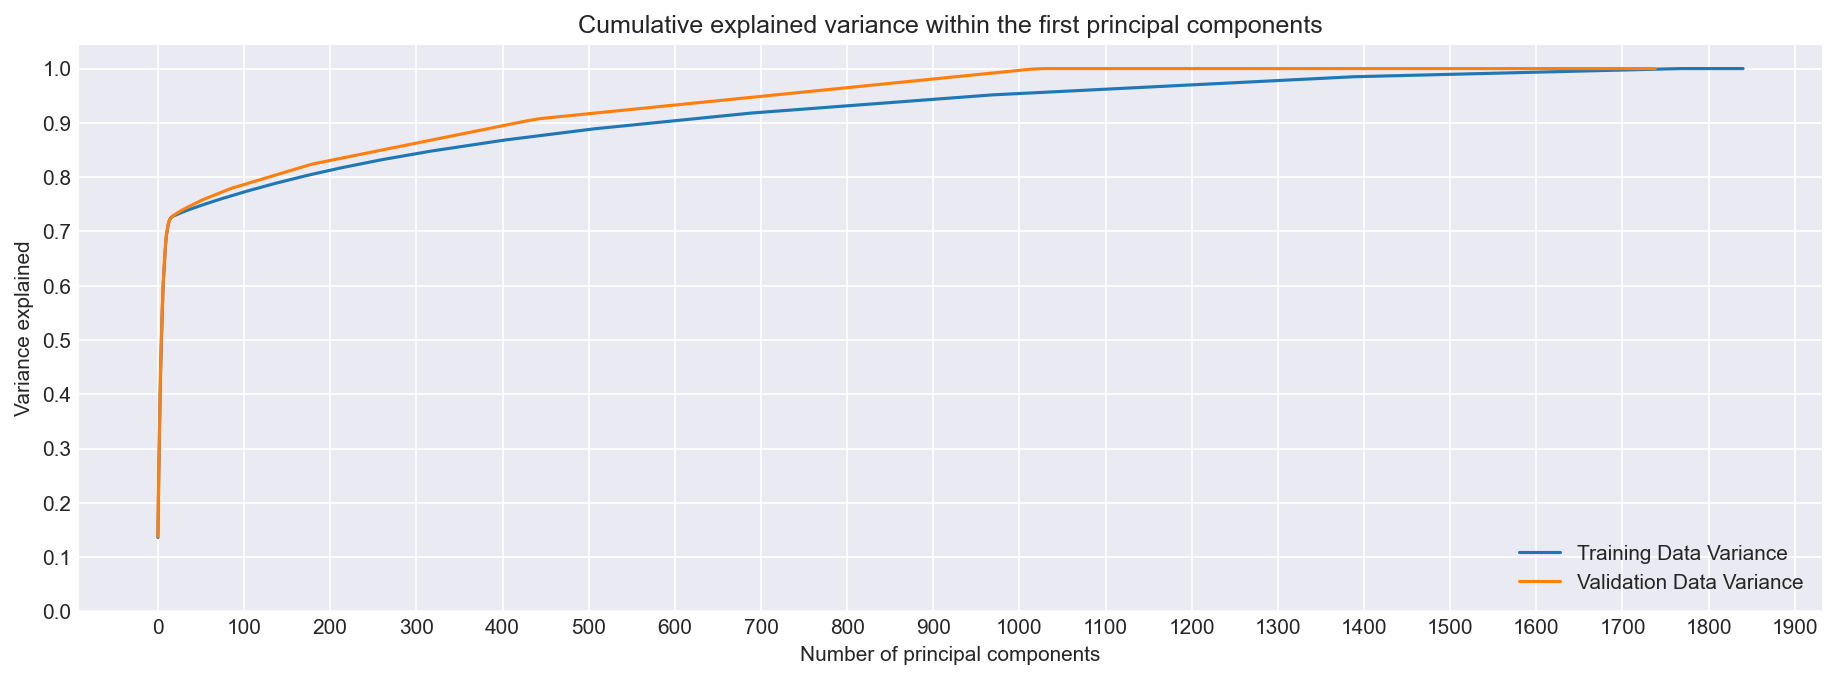

In [15]:
# Visualize cumulative explained variance
exp_var = np.array([sum(pca.explained_variance_ratio_[:(i + 1)]) for i in range(pca.n_components_)])
exp_var_val = np.array([sum(pca_val.explained_variance_ratio_[:(i + 1)]) for i in range(pca_val.n_components_)])

plt.style.use('seaborn-dark')
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(exp_var, label="Training Data Variance")
plt.plot(exp_var_val, label="Validation Data Variance")

plt.title("Cumulative explained variance within the first principal components")
plt.xlabel("Number of principal components")
plt.ylabel("Variance explained")
plt.xticks([_ for _ in np.arange(0, 2000, 100)])
plt.yticks([_ for _ in np.arange(0, 1.1, .1)])
plt.legend(loc='lower right')
plt.grid()
plt.show()

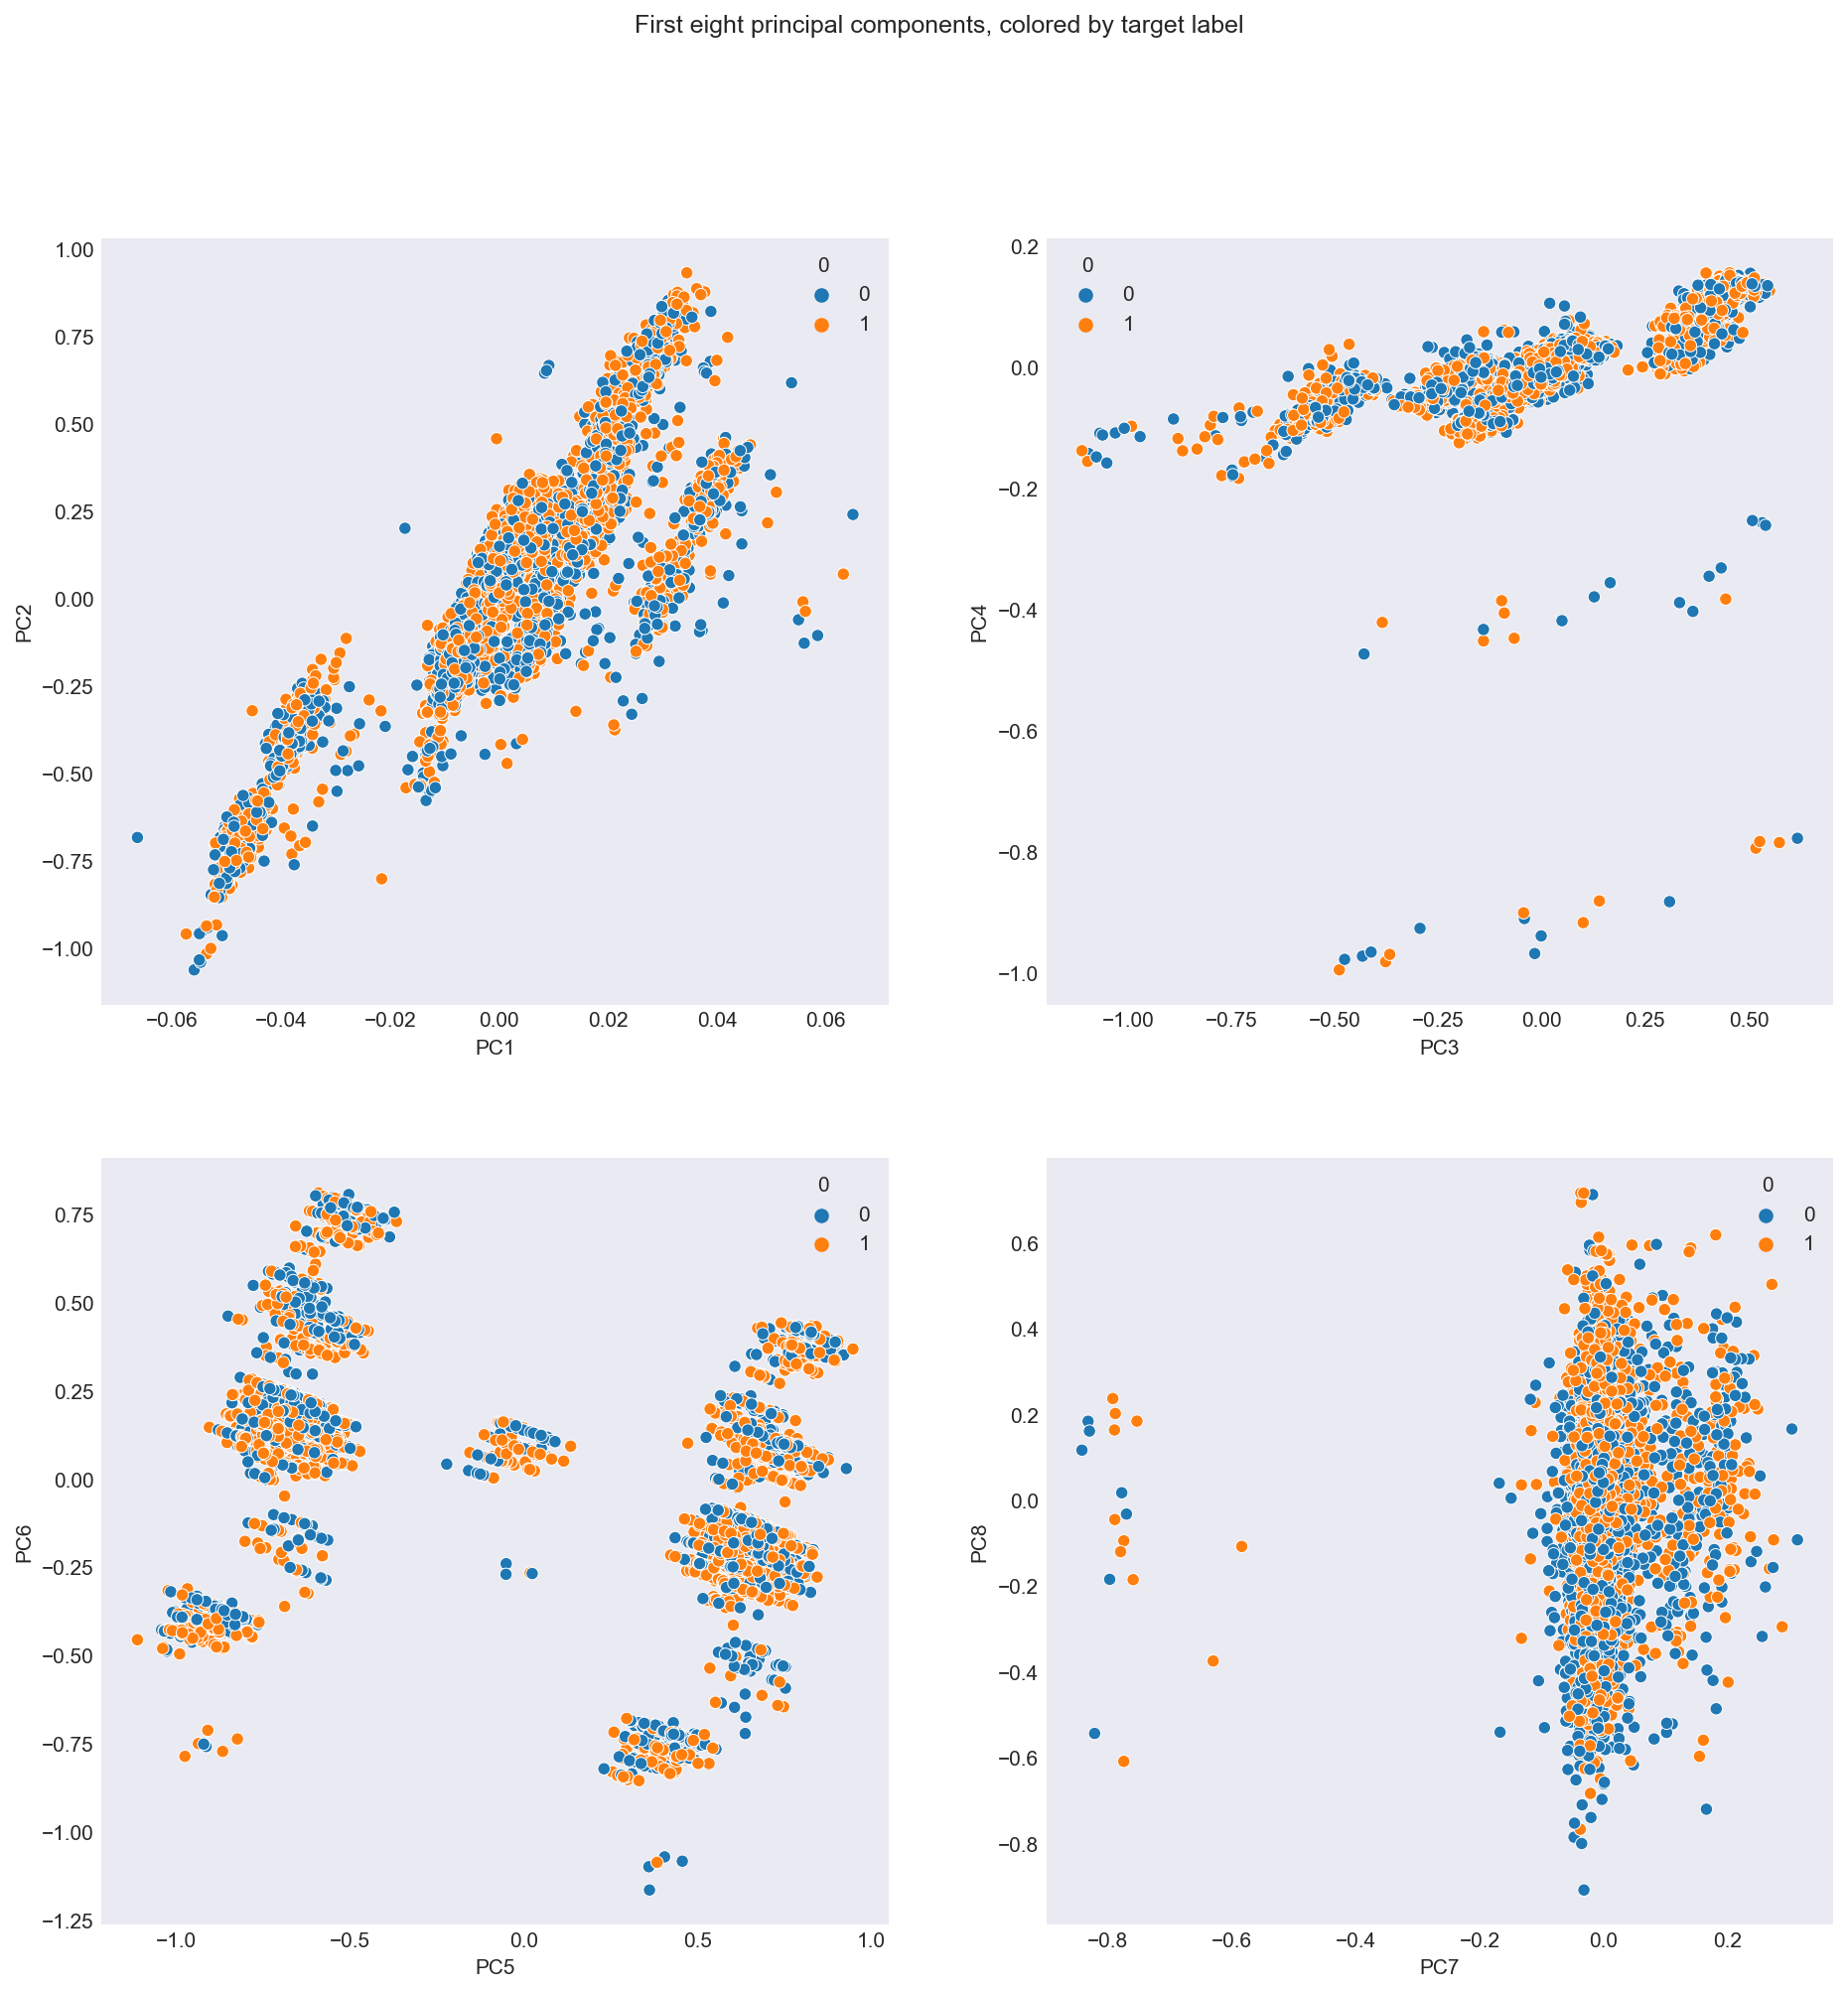

In [16]:
# Plot data projections
plt.figure(figsize=(15, 15), dpi=150)
plt.suptitle("First eight principal components, colored by target label")

plt.subplot(221)
plt.xlabel("PC1")
plt.ylabel("PC2")
sns.scatterplot(x=X_train_pca @ pca.components_[0],
                y=X_train_pca @ pca.components_[1],
                hue=y_train[0])

plt.subplot(222)
plt.xlabel("PC3")
plt.ylabel("PC4")
sns.scatterplot(x=X_train_pca @ pca.components_[2],
                y=X_train_pca @ pca.components_[3],
                hue=y_train[0])

plt.subplot(223)
plt.xlabel("PC5")
plt.ylabel("PC6")
sns.scatterplot(x=X_train_pca @ pca.components_[4],
                y=X_train_pca @ pca.components_[5],
                hue=y_train[0])

plt.subplot(224)
plt.xlabel("PC7")
plt.ylabel("PC8")
sns.scatterplot(x=X_train_pca @ pca.components_[6],
                y=X_train_pca @ pca.components_[7],
                hue=y_train[0])

plt.show()

As an aside, after looking at the labeled scatter plots above, I don't hold too much stock in PCA revealing any better clue on the target label patterning.

# MODEL SELECTION
Defining some convenience methods here.

In [17]:
def build_model(layers:     List[tf.keras.layers.Layer],
                optimizer:  tf.keras.optimizers.Optimizer | str,
                loss:       tf.keras.losses.Loss | str,
                metrics:    List[str]) -> tf.keras.models.Model:
    """Constructs and compiles a Keras model, then prints summary."""

    model = Sequential(layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

    return model

In [18]:
def plot_history(hist1, hist2, model):
    """Visualizes training performance over two spaces."""
    performance_1 = pd.DataFrame(hist1.history)
    performance_2 = pd.DataFrame(hist2.history)

    plt.figure(figsize=(15, 5), dpi=150)
    plt.suptitle(f'Training Performance (Learning Rate: {model.optimizer.learning_rate.numpy():.4f})')

    # feature space
    plt.subplot(121)
    plt.title("History 1")
    plt.plot(performance_1['accuracy'], label='Training')
    plt.plot(performance_1['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1)
    plt.legend(loc='lower right')

    # pca latent space
    plt.subplot(122)
    plt.title("History 2")
    plt.plot(performance_2['accuracy'], label='Training')
    plt.plot(performance_2['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1)
    plt.legend(loc='lower right')

    plt.show()

# MODEL SELECTION: Trial 1
Now that I have the feature space `X_train`/`X_val` and the PCA latent space `X_train_pca`/`X_val_pca`, I will predict over both spaces with a low-depth neural net.

In [19]:
# Define model
layers_1 = [Dense(100, 'relu', input_shape=(X_train.shape[1],)),
            Dense(200, 'relu'),
            Dense(100, 'relu'),
            Dropout(0.25),

            Dense(200, 'relu'),
            Dense(300, 'relu'),
            Dense(200, 'relu'),
            Dense(100, 'relu'),
            Dropout(0.25),

            Dense(50, 'relu'),
            Dense(25, 'relu'),
            Dense(1, 'sigmoid')]

opt_1 = Adam(learning_rate=0.0005,
             beta_1=0.99,
             beta_2=0.99)

model_1 = build_model(layers_1, opt_1, 'mse', ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               184200    
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               20200     
                                                                 
 dense_4 (Dense)             (None, 300)               60300     
                                                                 
 dense_5 (Dense)             (None, 200)               6

In [20]:
# Fit model to feature space
history_1 = model_1.fit(X_train, y_train,
                        epochs=100, verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100


2022-05-11 13:46:02.136518: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


218/218 [==============================] - 1s 4ms/step - loss: 0.2082 - accuracy: 0.6844 - val_loss: 0.1879 - val_accuracy: 0.7263
Epoch 2/100
218/218 [==============================] - 1s 2ms/step - loss: 0.1693 - accuracy: 0.7578 - val_loss: 0.1835 - val_accuracy: 0.7274
Epoch 3/100
218/218 [==============================] - 1s 2ms/step - loss: 0.1350 - accuracy: 0.8050 - val_loss: 0.2029 - val_accuracy: 0.7125
Epoch 4/100
218/218 [==============================] - 1s 3ms/step - loss: 0.0993 - accuracy: 0.8638 - val_loss: 0.2265 - val_accuracy: 0.6855
Epoch 5/100
218/218 [==============================] - 1s 2ms/step - loss: 0.0707 - accuracy: 0.9032 - val_loss: 0.2524 - val_accuracy: 0.6837
Epoch 6/100
218/218 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9333 - val_loss: 0.2608 - val_accuracy: 0.6734
Epoch 7/100
218/218 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9484 - val_loss: 0.2731 - val_accuracy: 0.6883
Epoch 8/100

In [21]:
# Fit model to PCA latent space
history_pca_1 = model_1.fit(X_train_pca, y_train,
                            epochs=100, verbose=1,
                            validation_data=(X_val_pca, y_val))

Epoch 1/100
218/218 [==============================] - 1s 3ms/step - loss: 0.4443 - accuracy: 0.5554 - val_loss: 0.4425 - val_accuracy: 0.5572
Epoch 2/100
218/218 [==============================] - 1s 2ms/step - loss: 0.4392 - accuracy: 0.5604 - val_loss: 0.4363 - val_accuracy: 0.5624
Epoch 3/100
218/218 [==============================] - 1s 2ms/step - loss: 0.3840 - accuracy: 0.5739 - val_loss: 0.3392 - val_accuracy: 0.5745
Epoch 4/100
218/218 [==============================] - 1s 3ms/step - loss: 0.3292 - accuracy: 0.5902 - val_loss: 0.3200 - val_accuracy: 0.5808
Epoch 5/100
218/218 [==============================] - 1s 4ms/step - loss: 0.2566 - accuracy: 0.5831 - val_loss: 0.2301 - val_accuracy: 0.5520
Epoch 6/100
218/218 [==============================] - 1s 3ms/step - loss: 0.2083 - accuracy: 0.6823 - val_loss: 0.1997 - val_accuracy: 0.7050
Epoch 7/100
218/218 [==============================] - 1s 3ms/step - loss: 0.1840 - accuracy: 0.7423 - val_loss: 0.1872 - val_accuracy: 0.7211

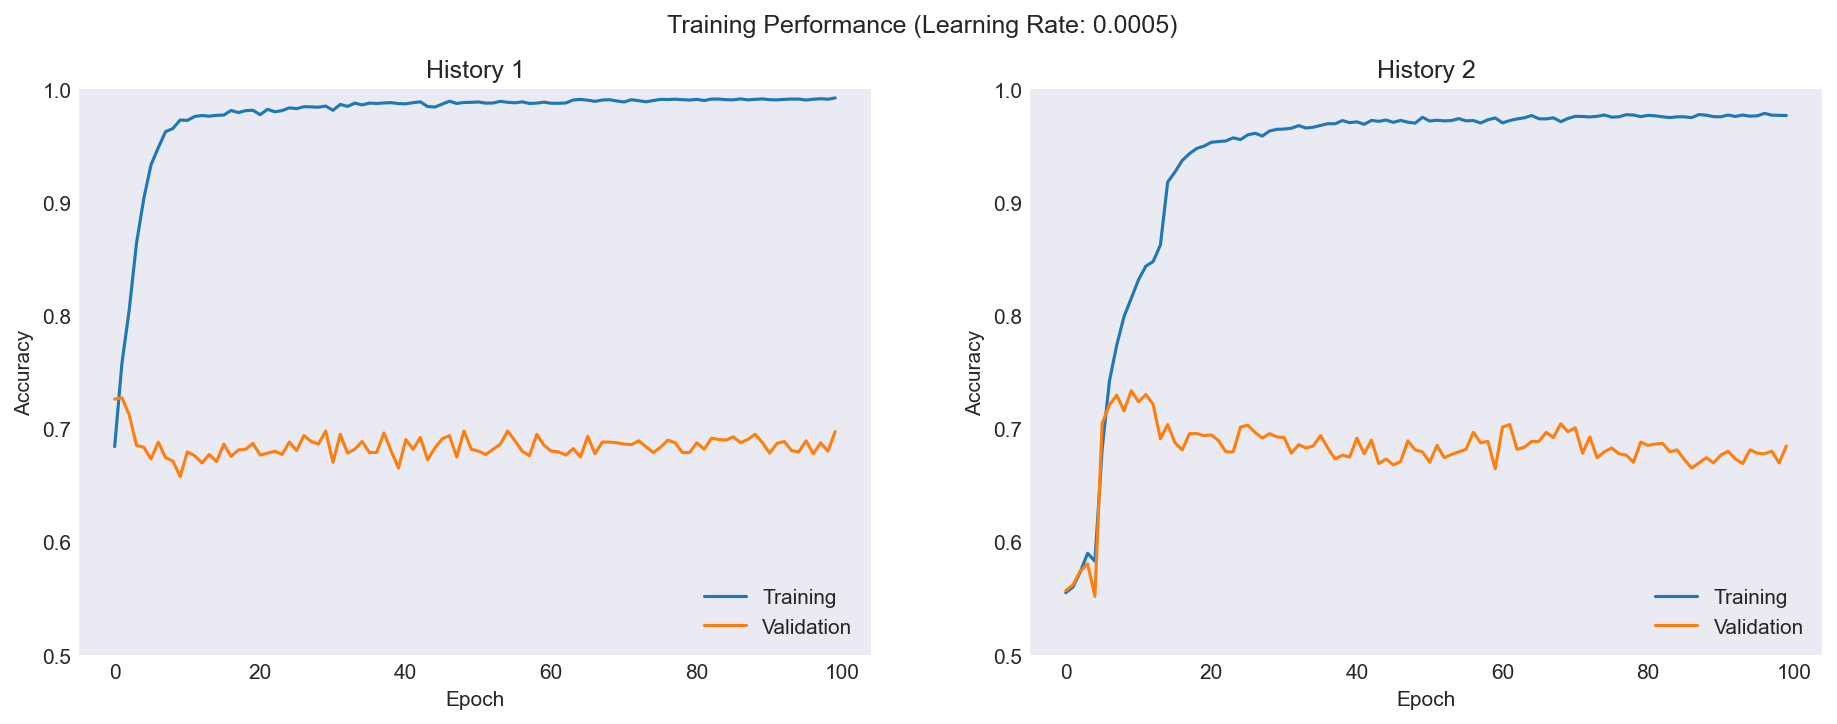

In [22]:
# Visualize training performance over both spaces
plot_history(history_1, history_pca_1, model_1)

# MODEL SELECTION: Trial 2
Clearly, the model overfit to the data. I wonder if I went a little heavy on the hidden layers and hidden neurons. I'll simplify the model and test performance again.

In [23]:
# Define simpler model
layers_2 = [Dense(64, 'relu', input_shape=(X_train.shape[1],)),
            Dense(128, 'relu'),
            Dense(64, 'relu'),
            Dense(1, 'sigmoid')]

opt_2 = Adam(learning_rate=0.0008,
             beta_1=0.98,
             beta_2=0.98)

model_2 = build_model(layers_2, opt_2, 'mse', ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                117888    
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 134,529
Trainable params: 134,529
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fit model to feature space
history_2 = model_2.fit(X_train, y_train,
                        epochs=100, verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100
218/218 [==============================] - 1s 3ms/step - loss: 0.2012 - accuracy: 0.7123 - val_loss: 0.1791 - val_accuracy: 0.7343
Epoch 2/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1462 - accuracy: 0.7863 - val_loss: 0.1800 - val_accuracy: 0.7234
Epoch 3/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1112 - accuracy: 0.8447 - val_loss: 0.2038 - val_accuracy: 0.6981
Epoch 4/100
218/218 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.8824 - val_loss: 0.2260 - val_accuracy: 0.6895
Epoch 5/100
218/218 [==============================] - 0s 1ms/step - loss: 0.0673 - accuracy: 0.9120 - val_loss: 0.2435 - val_accuracy: 0.6780
Epoch 6/100
218/218 [==============================] - 0s 1ms/step - loss: 0.0537 - accuracy: 0.9284 - val_loss: 0.2557 - val_accuracy: 0.6803
Epoch 7/100
218/218 [==============================] - 0s 1ms/step - loss: 0.0407 - accuracy: 0.9462 - val_loss: 0.2654 - val_accuracy: 0.6809

In [25]:
# Fit model to PCA latent space
history_pca_2 = model_2.fit(X_train_pca, y_train,
                            epochs=100, verbose=1,
                            validation_data=(X_val_pca, y_val))

Epoch 1/100
218/218 [==============================] - 0s 1ms/step - loss: 0.4345 - accuracy: 0.5647 - val_loss: 0.4375 - val_accuracy: 0.5607
Epoch 2/100
218/218 [==============================] - 0s 1ms/step - loss: 0.4150 - accuracy: 0.5835 - val_loss: 0.4303 - val_accuracy: 0.5681
Epoch 3/100
218/218 [==============================] - 0s 1ms/step - loss: 0.4049 - accuracy: 0.5936 - val_loss: 0.4206 - val_accuracy: 0.5768
Epoch 4/100
218/218 [==============================] - 0s 1ms/step - loss: 0.3956 - accuracy: 0.6014 - val_loss: 0.4114 - val_accuracy: 0.5808
Epoch 5/100
218/218 [==============================] - 0s 1ms/step - loss: 0.3825 - accuracy: 0.6140 - val_loss: 0.3999 - val_accuracy: 0.5923
Epoch 6/100
218/218 [==============================] - 0s 985us/step - loss: 0.3466 - accuracy: 0.6386 - val_loss: 0.3303 - val_accuracy: 0.6371
Epoch 7/100
218/218 [==============================] - 0s 1ms/step - loss: 0.2778 - accuracy: 0.6854 - val_loss: 0.2902 - val_accuracy: 0.65

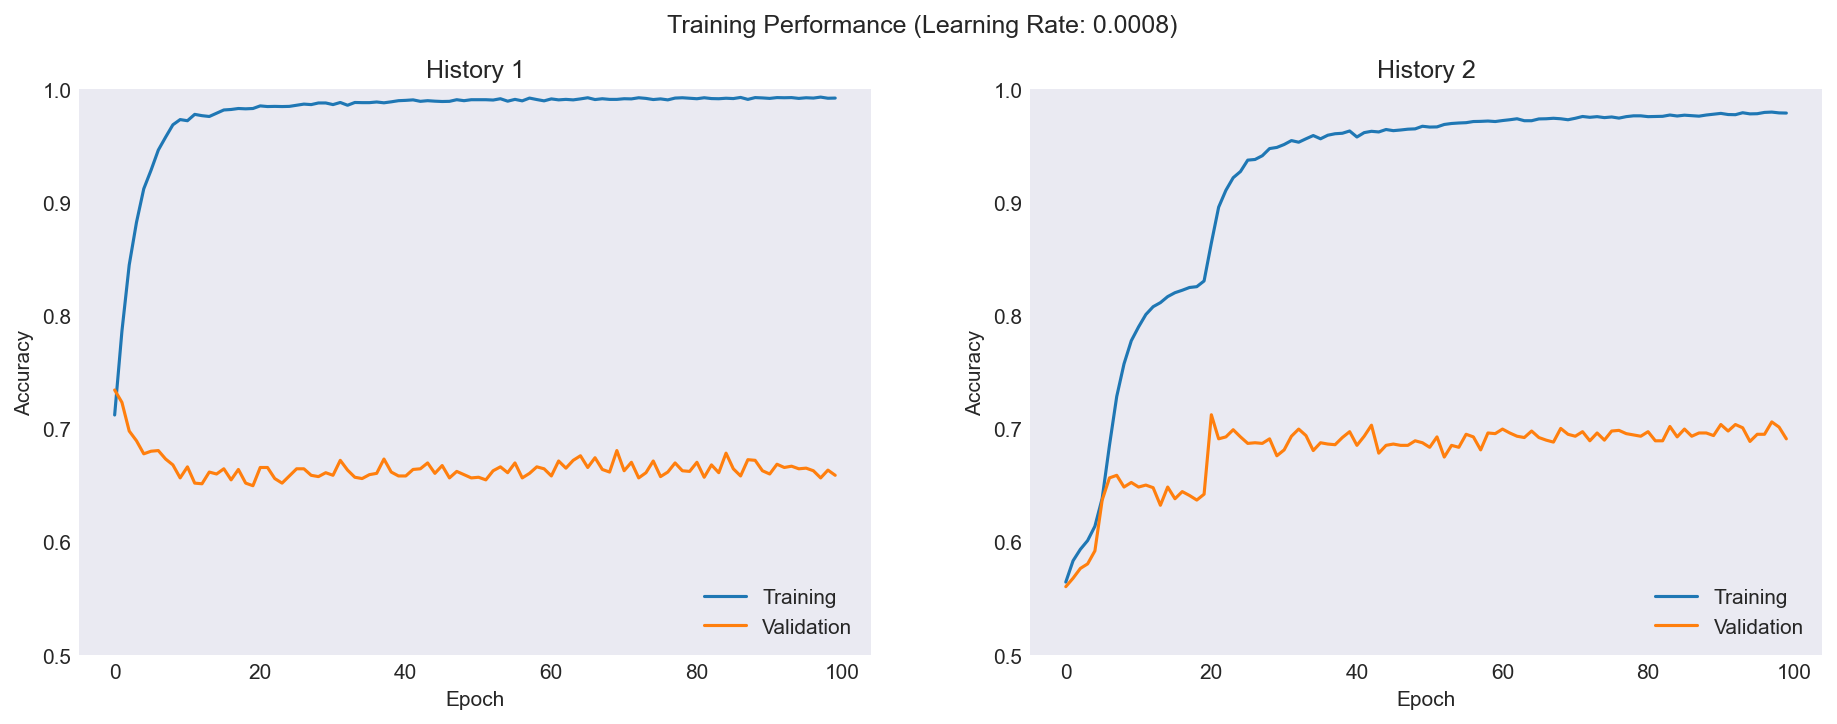

In [26]:
# Visualize training performance over both spaces
plot_history(history_2, history_pca_2, model_2)

# FEATURE ENGINEERING: Trial 3
Even with a simpler model, it still heavily overfit to the data. Also, in both trials, the neural network performance about the same on the feature space and the latent space. This is possibly because I'm not dropping any principal components, so the PCA space embedding and the normal feature embedding can be represented as linear transformations of each other, which the neural network may have learned.
<br>
With these observations in mind, I will forgo the effort for principal component decomposition. Instead, I'll focus on encoding categorical features more efficiently so that their information can be extracted better.

In [27]:
# Clean up the features

# `Name` and `PassengerId` are unique identifiers, probably not highly correlated to the target
X_clean = X.drop(['Name', 'PassengerId'], axis=1)

# Only dummy encode features with small (<5) expansion
expand_cols = ['HomePlanet', 'Destination']
onehot_cols = pd.get_dummies(X_clean[expand_cols])
X_clean = X_clean.drop(expand_cols, axis=1)
X_clean = X_clean.join(onehot_cols)

# Binarize boolean features
for col in ('CryoSleep', 'VIP'):
    column = X_clean[col].copy()
    column[column.isna()] = 0
    column = np.zeros(column.shape) + column.to_numpy()
    column = pd.Series(column, dtype='uint8')
    X_clean[col] = column

# Split `Cabin` encoding by splitting it into 3 features
cabins = {'Cabin1': [],
          'Cabin2': [],
          'Cabin3': []}

for i, row in X_clean.copy().iterrows():
    if type(row['Cabin']) == str:
        c1, c2, c3 = row['Cabin'].split('/')

        # Numeralize cabin location by summing ASCII values
        cabins['Cabin1'].append(sum(ord(c) for c in str(c1)))
        cabins['Cabin2'].append(sum(ord(c) for c in str(c2)))
        cabins['Cabin3'].append(sum(ord(c) for c in str(c3)))

# Semanticize cabin location by min-max scaling the ASCII value sums
for i, cabin in cabins.items():
    cabins[i] = np.array(cabin)
    cabins[i] = (cabins[i] - cabins[i].min()) / (cabins[i].max() / cabins[i].min())

X_clean = X_clean.drop('Cabin', axis=1)
X_clean = X_clean.join(pd.DataFrame(cabins))

X_clean.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin1,Cabin2,Cabin3
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0.773810,0.000000,0.000000
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,0,0,0,1,3.869048,0.000000,2.891566
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,0,0,0,1,0.000000,0.000000,2.891566
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,0,0,1,0.000000,0.000000,2.891566
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,0,0,0,1,3.869048,0.220183,2.891566


In [28]:
# Normalize features between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)
X_scaled[X_scaled.isna()] = 0
X_scaled.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin1,Cabin2,Cabin3
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.052632,0.000000,0.0
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.0,0.0,0.0,0.0,1.0,0.263158,0.000000,1.0
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.0,0.0,0.0,0.0,1.0,0.263158,0.005882,1.0


In [29]:
# Split 20% of data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_clean, test_size=0.2, shuffle=True, random_state=0)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_val.shape=}")
print(f"{y_val.shape=}")

X_train.shape=(6954, 17)
y_train.shape=(6954, 1)
X_val.shape=(1739, 17)
y_val.shape=(1739, 1)


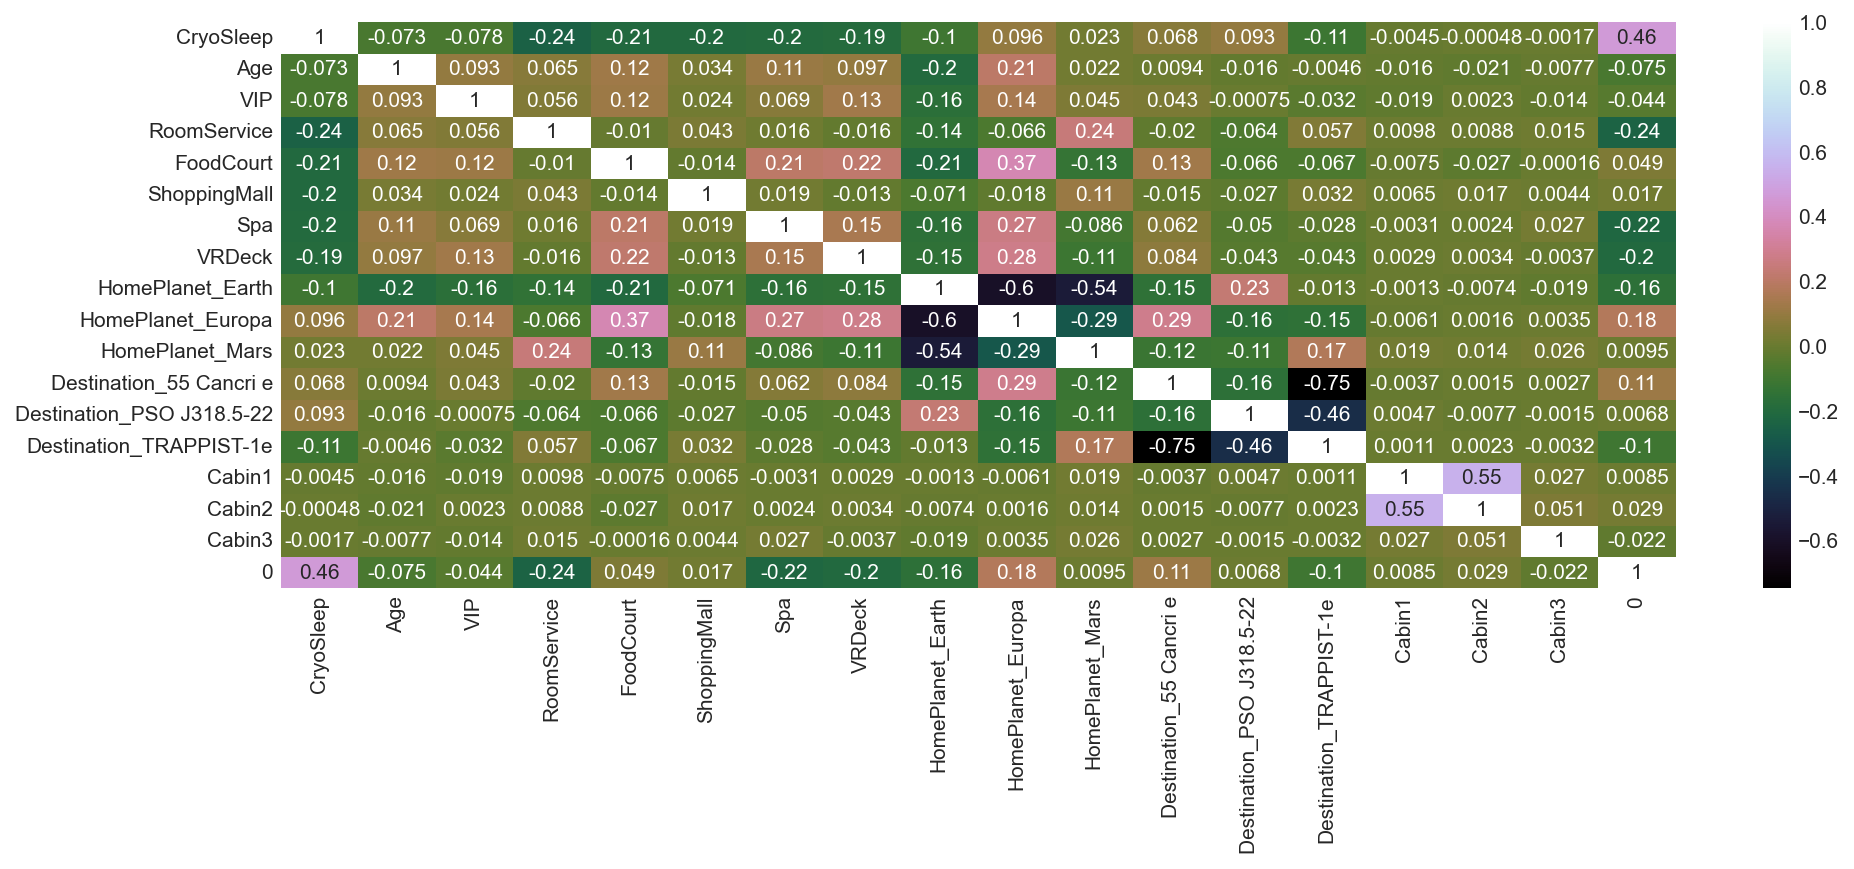

In [30]:
# Show feature correlation heatmap after preprocessing
plt.figure(figsize=(15, 5), dpi=150)
sns.heatmap(X_train.join(y_train).corr(), annot=True, cmap='cubehelix')
plt.show()

Now that the data is preprocessed, every feature shows up on the heatmap. Subsequently, we can see that `CryoSleep` seems to have a moderate positive correlation with the target, while `RoomService`, `Spa`, and `VRDeck` have a mild negative correlation with the target. Also of note, splitting `Cabin` into three features didn't seem to add to the feature's target correlation.

# FEATURE ENGINEERING: Trial 4

 I will re-engineer the feature set, taking into account the observations made on the heatmap above. I want to try to accentuate the correlations somehow.

In [31]:
# Clean up the features
X_clean = X.drop(['Name', 'PassengerId', 'Cabin'], axis=1)

# Only dummy encode features with small (<5) expansion
expand_cols = ['HomePlanet', 'Destination']
onehot_cols = pd.get_dummies(X_clean[expand_cols])
X_clean = X_clean.drop(expand_cols, axis=1)
X_clean = X_clean.join(onehot_cols)

# Binarize boolean features
for col in ('CryoSleep', 'VIP'):
    column = X_clean[col].copy()
    column[column.isna()] = 0
    column = np.zeros(column.shape) + column.to_numpy()
    column = pd.Series(column)
    X_clean[col] = column

X_clean.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,0,0,0,0,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,0,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,0,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,0,0,0,0,1


In [32]:
# Normalize features between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)
X_scaled[X_scaled.isna()] = 0
X_scaled.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.0,0.0,0.0,0.0,1.0


In [33]:
# Accentuate correlations through logistic expansion (experimental)
def logitistic_expansion(a: np.ndarray, magic: int) -> np.ndarray:
    """I'm making this up, but here's the objective:

    1. Take a range of data that is normalized between 0 and 1
    2. Accentuate the spread by making lower values lower and higher values higher.
    3. See if accentuating the spread improves correlation and model performance.

    Algorithm:
    - Subtract 0.5 from each value
        - Small values will have negative differences
        - Large values will have positive differences
    - Exponentiate the differences
        - Positive differences will create product > 1
        - Negative differences will create product < 1
    - Scale the value by the exponentiated difference
        - Smaller values will get smaller
        - Larger values will get larger

    Magic is the number of times the accentuation will occur.
    """
    return a * (np.e ** (a - 0.5)) ** magic

X_expanded = logitistic_expansion(X_scaled, 42)

In [34]:
# Split 20% of data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_clean, test_size=0.2, shuffle=True, random_state=0)
X_train_exp, X_val_exp, _, _ = train_test_split(X_expanded, y_clean, test_size=0.2, shuffle=True, random_state=0)

print(f"{X_train.shape=}")
print(f"{X_train_exp.shape=}")
print(f"{y_train.shape=}")
print(f"{X_val.shape=}")
print(f"{X_val_exp.shape=}")
print(f"{y_val.shape=}")

X_train.shape=(6954, 14)
X_train_exp.shape=(6954, 14)
y_train.shape=(6954, 1)
X_val.shape=(1739, 14)
X_val_exp.shape=(1739, 14)
y_val.shape=(1739, 1)


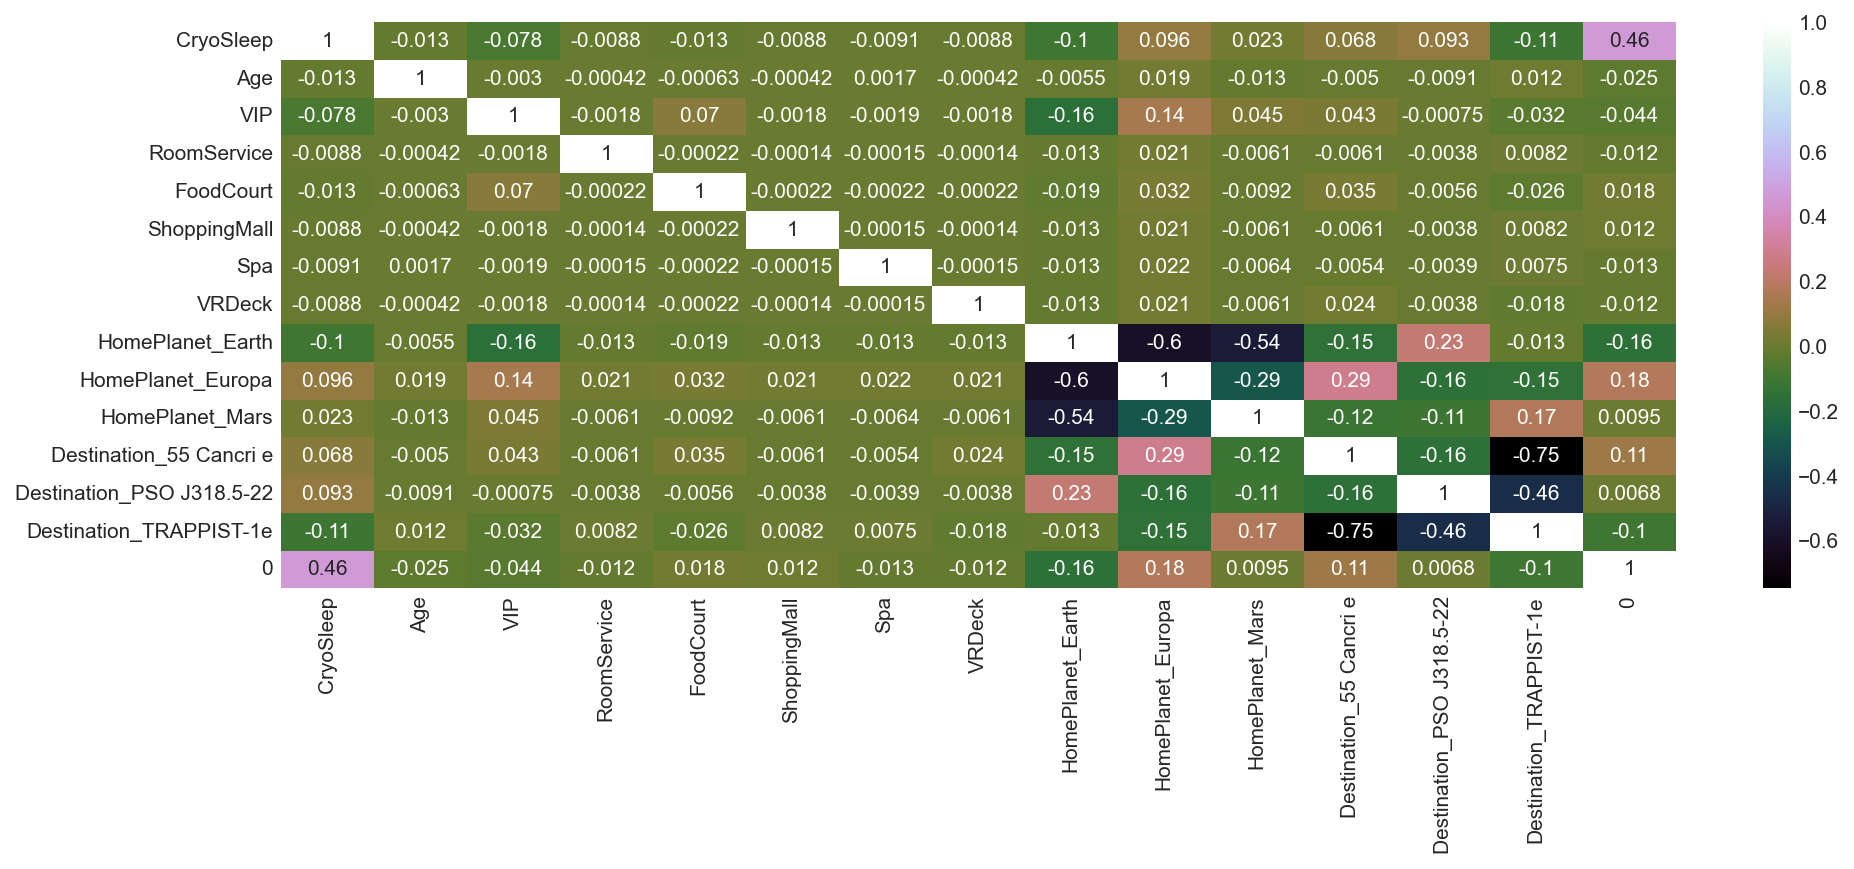

In [35]:
# Show feature correlation heatmap after preprocessing
plt.figure(figsize=(15, 5), dpi=150)
sns.heatmap(X_train_exp.join(y_train).corr(), annot=True, cmap='cubehelix')
plt.show()

# MODEL SELECTION: Trial 3
I can already tell that the expansion did not work as intended. I predict that the model will fail miserably on the expanded data, but we will try anyway, for science.

In [36]:
# Define another model
layers_3 = [Dense(64, 'relu', input_shape=(X_train.shape[1],)),
            Dense(128, 'relu'),
            Dense(64, 'relu'),
            Dense(1, 'sigmoid')]

opt_3 = Adam(learning_rate=0.0008,
             beta_1=0.98,
             beta_2=0.98)

model_3 = build_model(layers_3, opt_3, 'mse', ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                960       
                                                                 
 dense_15 (Dense)            (None, 128)               8320      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,601
Trainable params: 17,601
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fit model to feature space
history_3 = model_3.fit(X_train, y_train,
                        epochs=100, verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1923 - accuracy: 0.6999 - val_loss: 0.1786 - val_accuracy: 0.7504
Epoch 2/100
218/218 [==============================] - 0s 589us/step - loss: 0.1705 - accuracy: 0.7552 - val_loss: 0.1685 - val_accuracy: 0.7573
Epoch 3/100
218/218 [==============================] - 0s 642us/step - loss: 0.1596 - accuracy: 0.7652 - val_loss: 0.1605 - val_accuracy: 0.7573
Epoch 4/100
218/218 [==============================] - 0s 677us/step - loss: 0.1528 - accuracy: 0.7718 - val_loss: 0.1563 - val_accuracy: 0.7596
Epoch 5/100
218/218 [==============================] - 0s 733us/step - loss: 0.1492 - accuracy: 0.7788 - val_loss: 0.1513 - val_accuracy: 0.7671
Epoch 6/100
218/218 [==============================] - 0s 597us/step - loss: 0.1454 - accuracy: 0.7853 - val_loss: 0.1541 - val_accuracy: 0.7723
Epoch 7/100
218/218 [==============================] - 0s 639us/step - loss: 0.1440 - accuracy: 0.7890 - val_loss: 0.1489 - val_accu

In [38]:
# Fit model to feature space
history_3_exp = model_3.fit(X_train_exp, y_train,
                            epochs=100, verbose=1,
                            validation_data=(X_val_exp, y_val))

Epoch 1/100
218/218 [==============================] - 0s 979us/step - loss: 0.4694 - accuracy: 0.5306 - val_loss: 0.5037 - val_accuracy: 0.4963
Epoch 2/100
218/218 [==============================] - 0s 643us/step - loss: 0.5036 - accuracy: 0.4964 - val_loss: 0.5037 - val_accuracy: 0.4963
Epoch 3/100
218/218 [==============================] - 0s 669us/step - loss: 0.5036 - accuracy: 0.4964 - val_loss: 0.5037 - val_accuracy: 0.4963
Epoch 4/100
218/218 [==============================] - 0s 661us/step - loss: 0.5036 - accuracy: 0.4964 - val_loss: 0.5037 - val_accuracy: 0.4963
Epoch 5/100
218/218 [==============================] - 0s 655us/step - loss: 0.5036 - accuracy: 0.4964 - val_loss: 0.5037 - val_accuracy: 0.4963
Epoch 6/100
218/218 [==============================] - 0s 671us/step - loss: 0.5036 - accuracy: 0.4964 - val_loss: 0.5037 - val_accuracy: 0.4963
Epoch 7/100
218/218 [==============================] - 0s 654us/step - loss: 0.5036 - accuracy: 0.4964 - val_loss: 0.5037 - val_ac

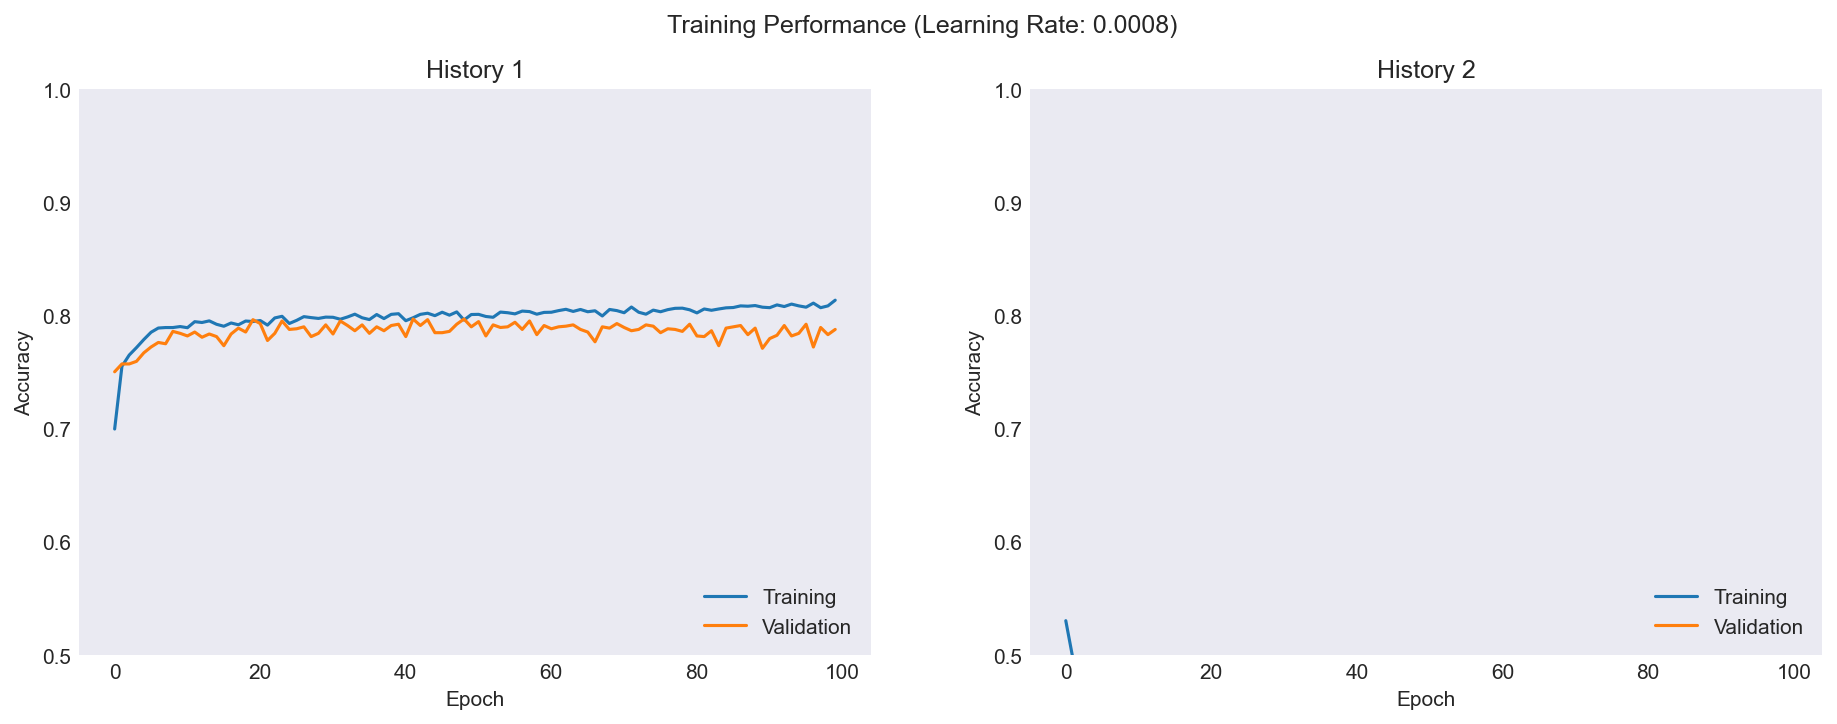

In [39]:
# Visualize training performance
plot_history(history_3, history_3_exp, model_3)

As predicted, model performance on the expanded data did very poorly. However, it is interesting to note that after dropping the `Cabin` feature entirely, the performance of the model on the data after only scaling is improved from before.

# FEATURE ENGINEERING: Trial 5
Seeing how dropping the `Cabin`, which had close-to-zero correlation, improved model performance, I will drop all of the other "neutral" features, hoping that it will reduce noise in the model's training and improve performance.

In [40]:
# Clean up the features
X_clean = X.drop(['Name', 'PassengerId', 'Cabin', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall'], axis=1)

# Only dummy encode features with small (<5) expansion
expand_cols = ['HomePlanet', 'Destination']
onehot_cols = pd.get_dummies(X_clean[expand_cols])
X_clean = X_clean.drop(expand_cols, axis=1)
X_clean = X_clean.join(onehot_cols)

# Binarize `CryoSleep`
cryo = X_clean['CryoSleep'].copy()
cryo[cryo.isna()] = 0
cryo = np.zeros(cryo.shape) + cryo.to_numpy()
cryo = pd.Series(cryo)
X_clean['CryoSleep'] = cryo

X_clean.head()

,CryoSleep,RoomService,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1,0.0,109.0,549.0,44.0,1,0,0,0,0,1
2,0.0,43.0,6715.0,49.0,0,1,0,0,0,1
3,0.0,0.0,3329.0,193.0,0,1,0,0,0,1
4,0.0,303.0,565.0,2.0,1,0,0,0,0,1


In [41]:
# Normalize features between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)
X_scaled[X_scaled.isna()] = 0
X_scaled.head()

,CryoSleep,RoomService,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.007608,0.024500,0.001823,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.003001,0.299670,0.002030,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.000000,0.148563,0.007997,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.021149,0.025214,0.000083,1.0,0.0,0.0,0.0,0.0,1.0


In [42]:
# Split 20% of data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_clean, test_size=0.2, shuffle=True, random_state=0)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_val.shape=}")
print(f"{y_val.shape=}")

X_train.shape=(6954, 10)
y_train.shape=(6954, 1)
X_val.shape=(1739, 10)
y_val.shape=(1739, 1)


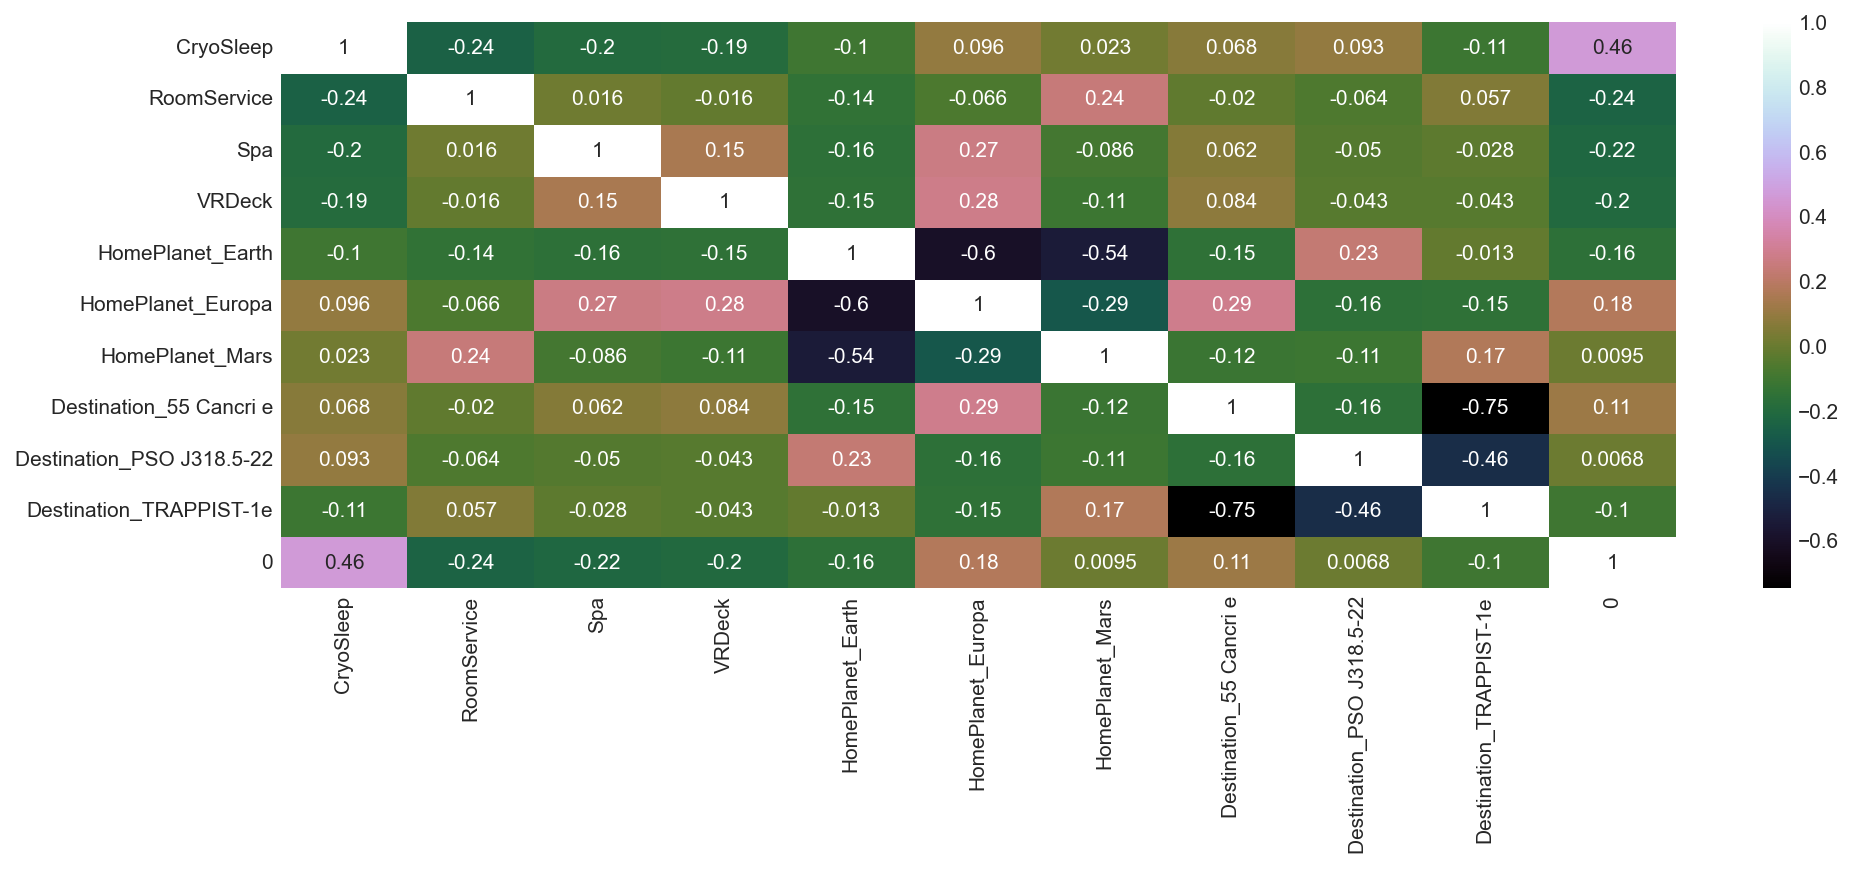

In [43]:
# Show feature correlation heatmap after preprocessing
plt.figure(figsize=(15, 5), dpi=150)
sns.heatmap(X_train.join(y_train).corr(), annot=True, cmap='cubehelix')
plt.show()

# MODEL SELECTION: Trial 4
Now that only features with a non-neutral correlation factor are in the feature set, I want to see how performance is affected.

In [44]:
# Define another model
layers_4 = [Dense(64, 'relu', input_shape=(X_train.shape[1],)),
            Dense(128, 'relu'),
            Dense(64, 'relu'),
            Dense(1, 'sigmoid')]

opt_4 = Adam(learning_rate=0.0008,
             beta_1=0.98,
             beta_2=0.98)

model_4 = build_model(layers_4, opt_4, 'mse', ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                704       
                                                                 
 dense_19 (Dense)            (None, 128)               8320      
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,345
Trainable params: 17,345
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Fit model to feature space
history_4 = model_4.fit(X_train, y_train,
                        epochs=100, verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1907 - accuracy: 0.7177 - val_loss: 0.1810 - val_accuracy: 0.7499
Epoch 2/100
218/218 [==============================] - 0s 848us/step - loss: 0.1749 - accuracy: 0.7426 - val_loss: 0.1737 - val_accuracy: 0.7372
Epoch 3/100
218/218 [==============================] - 0s 879us/step - loss: 0.1671 - accuracy: 0.7515 - val_loss: 0.1633 - val_accuracy: 0.7493
Epoch 4/100
218/218 [==============================] - 0s 905us/step - loss: 0.1606 - accuracy: 0.7541 - val_loss: 0.1586 - val_accuracy: 0.7614
Epoch 5/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1569 - accuracy: 0.7622 - val_loss: 0.1552 - val_accuracy: 0.7625
Epoch 6/100
218/218 [==============================] - 0s 869us/step - loss: 0.1548 - accuracy: 0.7669 - val_loss: 0.1554 - val_accuracy: 0.7545
Epoch 7/100
218/218 [==============================] - 0s 814us/step - loss: 0.1522 - accuracy: 0.7721 - val_loss: 0.1615 - val_accura

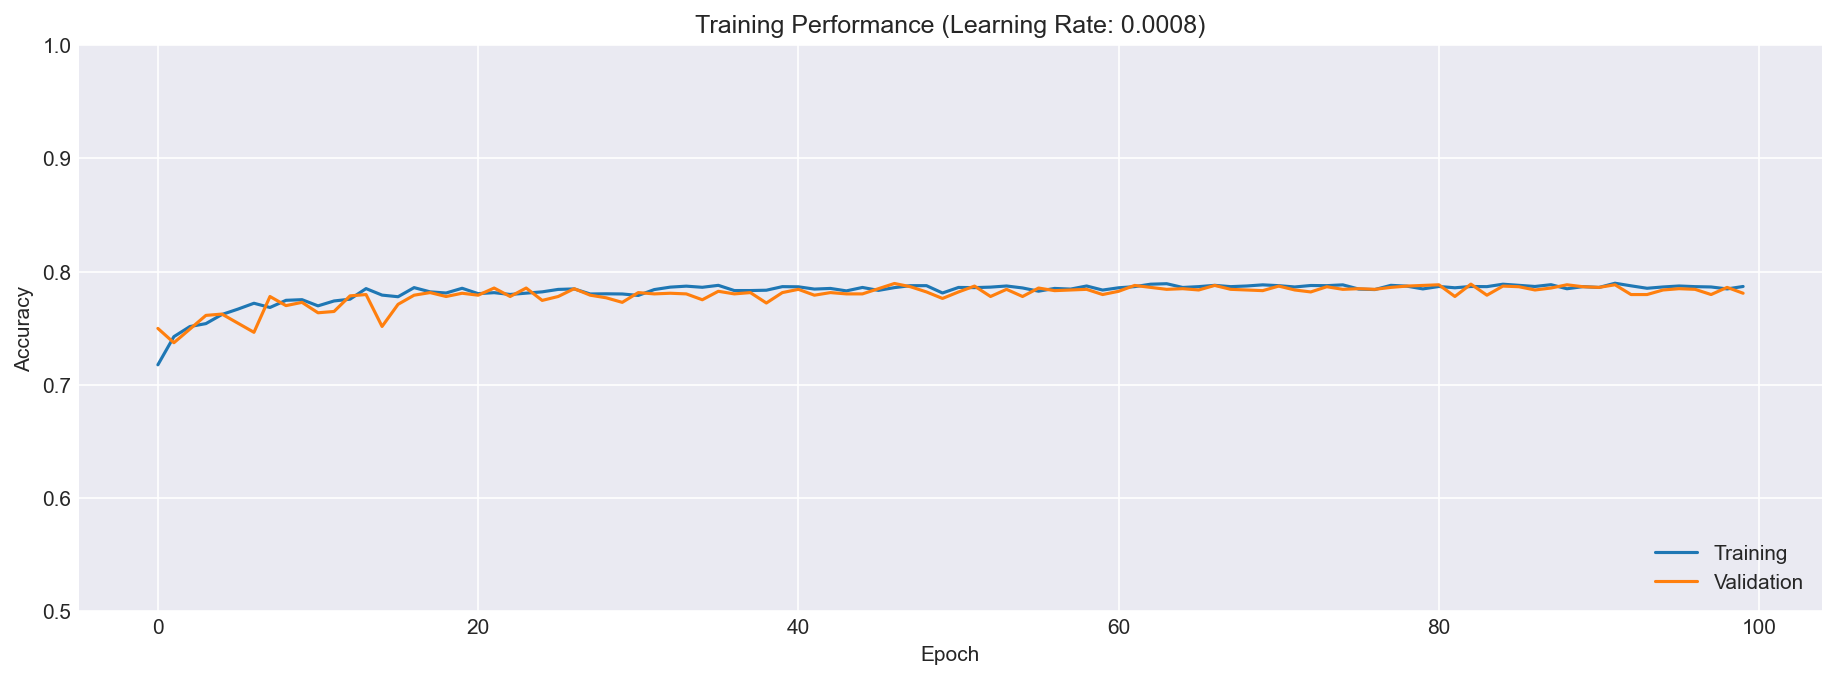

In [46]:
# Visualize training performance
performance = pd.DataFrame(history_4.history)

plt.figure(figsize=(15, 5), dpi=150)
plt.plot(performance['accuracy'], label='Training')
plt.plot(performance['val_accuracy'], label='Validation')

plt.title(f"Training Performance (Learning Rate: {model_4.optimizer.learning_rate.numpy():.4f})")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)

plt.legend(loc='lower right')
plt.grid()
plt.show()

The model performance did improve, but it seems to have leveled out just under 80% accuracy.

# MODEL SELECTION: Trial 5
I will try to tune the model architecture and the optimizer to improve performance.

In [47]:
# Define another model
layers_5 = [Dense(64, 'relu', input_shape=(X_train.shape[1],)),
            Dense(128, 'relu'),
            Dropout(0.1),

            Dense(128, 'relu'),
            Dense(128, 'relu'),
            Dropout(0.1),

            Dense(128, 'relu'),
            Dense(128, 'relu'),
            Dropout(0.1),

            Dense(64, 'relu'),
            Dense(1, 'sigmoid')]

model_5 = build_model(layers_5, 'adam', 'mse', ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                704       
                                                                 
 dense_23 (Dense)            (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 128)              

In [48]:
# Fit model to feature space
history_5 = model_5.fit(X_train, y_train,
                        epochs=100, verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/100
218/218 [==============================] - 1s 2ms/step - loss: 0.1922 - accuracy: 0.7056 - val_loss: 0.1750 - val_accuracy: 0.7499
Epoch 2/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1689 - accuracy: 0.7514 - val_loss: 0.1628 - val_accuracy: 0.7596
Epoch 3/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1636 - accuracy: 0.7535 - val_loss: 0.1606 - val_accuracy: 0.7539
Epoch 4/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1581 - accuracy: 0.7652 - val_loss: 0.1514 - val_accuracy: 0.7752
Epoch 5/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1561 - accuracy: 0.7692 - val_loss: 0.1646 - val_accuracy: 0.7504
Epoch 6/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1548 - accuracy: 0.7706 - val_loss: 0.1541 - val_accuracy: 0.7746
Epoch 7/100
218/218 [==============================] - 0s 1ms/step - loss: 0.1547 - accuracy: 0.7668 - val_loss: 0.1508 - val_accuracy: 0.7786

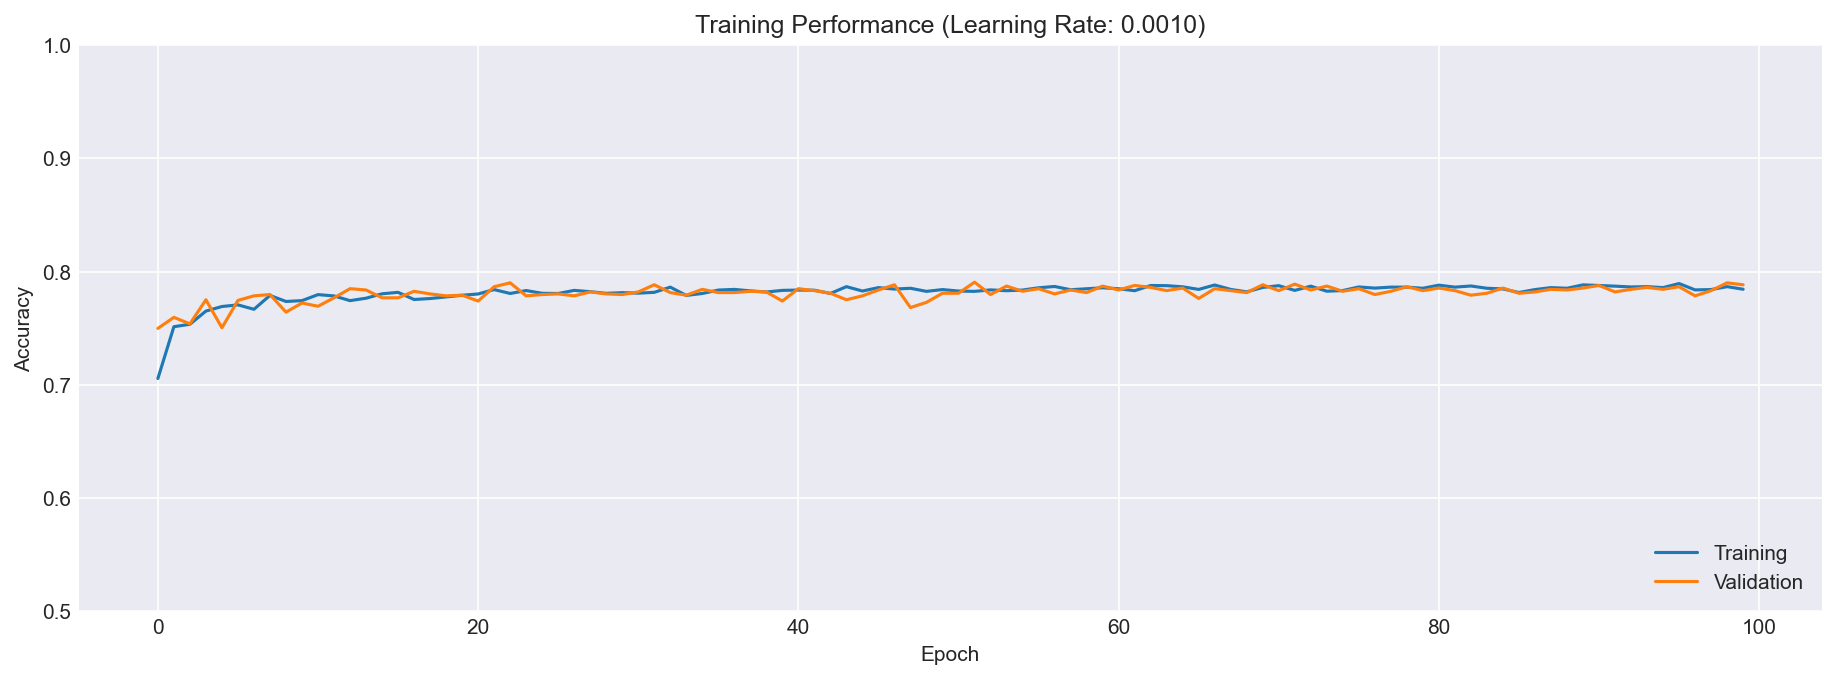

In [49]:
# Visualize training performance
performance = pd.DataFrame(history_5.history)

plt.figure(figsize=(15, 5), dpi=150)
plt.plot(performance['accuracy'], label='Training')
plt.plot(performance['val_accuracy'], label='Validation')

plt.title(f"Training Performance (Learning Rate: {model_5.optimizer.learning_rate.numpy():.4f})")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)

plt.legend(loc='lower right')
plt.grid()
plt.show()

# CONCLUSION

Through this analysis, I've learned a few key things:
- PCA doesn't magically make any dataset linearly separable.
- Having way too many features will cause the model to overfit quickly.
- Accentuating separation of scaled values actually compresses correlation.
- Removing features with close-to-zero target correlation can reduce noise and improve performance.
- Good data is important, but the existence of a ground-truth relationship to begin with is even more important.

That last point is my conclusion: from my observations on the data presented, I conclude that there is a limited level of prediction accuracy that can be reached. My supporting evidence is that after preprocessing the data and tuning the model, training and validation performance leveled out with each other, which I interpret as the model learning the data as well as it can given the nature of the data, itself.

# SUBMISSION
Now that I've reached the end of the analysis and model selection, I will now predict on the test data and submit to Kaggle.

In [50]:
# Load the test dataset
X_test = pd.read_csv('./data/test.csv')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [51]:
# Clean up the features
X_test_clean = X_test.drop(['Name', 'PassengerId', 'Cabin', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall'], axis=1)

# Only dummy encode features with small (<5) expansion
expand_cols = ['HomePlanet', 'Destination']
onehot_cols = pd.get_dummies(X_test_clean[expand_cols])
X_test_clean = X_test_clean.drop(expand_cols, axis=1)
X_test_clean = X_test_clean.join(onehot_cols)

# Binarize `CryoSleep`
cryo = X_test_clean['CryoSleep'].copy()
cryo[cryo.isna()] = 0
cryo = np.zeros(cryo.shape) + cryo.to_numpy()
cryo = pd.Series(cryo)
X_test_clean['CryoSleep'] = cryo

X_test_clean.head()

,CryoSleep,RoomService,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,1.0,0.0,0.0,0.0,1,0,0,0,0,1
1,0.0,0.0,2823.0,0.0,1,0,0,0,0,1
2,1.0,0.0,0.0,0.0,0,1,0,1,0,0
3,0.0,0.0,181.0,585.0,0,1,0,0,0,1
4,0.0,10.0,0.0,0.0,1,0,0,0,0,1


In [52]:
# Normalize features between 0 and 1
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test_clean)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_clean.columns)
X_test_scaled[X_test_scaled.isna()] = 0
X_test_scaled.head()

,CryoSleep,RoomService,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,1.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.142260,0.000000,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.000000,0.009121,0.026266,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.000865,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0


In [53]:
prediction = model_5.predict(X_test_scaled)
prediction

array([[5.9993708e-01],
       [8.6918473e-04],
       [9.9703538e-01],
       ...,
       [9.8289967e-01],
       [5.8839399e-01],
       [6.4881718e-01]], dtype=float32)

In [54]:
submission = pd.DataFrame(X_test['PassengerId']).join(pd.DataFrame(prediction))
submission.columns = ['PassengerId', 'Transported']
submission['Transported'] = submission['Transported'].apply(lambda x: True if x >= 0.5 else False)
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [55]:
submission.to_csv('submission.csv', index=False)

# FINAL RESULT: Placed 1366/2057 with score (accuracy) of 0.78372

<img src="kaggle_placement.png">